In [1]:
"""

A basic momentum strategy:
- Buy if the rolling return over the last 'lookback' days is positive.
- Sell if it's negative.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01"):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }, inplace=True)
    df.dropna(inplace=True)
    return df

In [2]:
def momentum_signals(df, lookback=20):
    """
    rolling_return = close[t] / close[t - lookback] - 1
    If rolling_return > 0 => buy (signal=1)
    If rolling_return < 0 => sell (signal=-1)
    """
    df['rolling_return'] = df['close'] / df['close'].shift(lookback) - 1
    df['signal'] = 0
    df.loc[df['rolling_return'] > 0, 'signal'] = 1
    df.loc[df['rolling_return'] < 0, 'signal'] = -1
    return df

In [3]:
def backtest_strategy(df, initial_capital=10000):
    df['returns'] = df['close'].pct_change().fillna(0)
    df['strategy_returns'] = df['signal'].shift(1).fillna(0) * df['returns']
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()

    final_value = initial_capital * df['cumulative_strategy'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital

    drawdown = (
        (df['cumulative_strategy'].cummax() - df['cumulative_strategy'])
        / df['cumulative_strategy'].cummax()
    )
    max_drawdown = drawdown.max()
    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    
    result = {
        "Initial Capital": initial_capital,
        "Final Portfolio Value": round(final_value, 2),
        "Total Return": f"{total_return*100:.2f}%",
        "Max Drawdown": f"{max_drawdown*100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }
    return df, result

In [4]:
def plot_results(df):
    fig, ax = plt.subplots()
    ax.plot(df.index, df['close'], label='Price')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', label='Buy')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', label='Sell')
    ax.set_title("Momentum Strategy - Price & Signals")
    ax.legend()
    plt.show()
    
    plt.plot(df.index, df['cumulative_market'], label='Market Returns')
    plt.plot(df.index, df['cumulative_strategy'], label='Strategy Returns')
    plt.title("Momentum Strategy - Equity Curve")
    plt.legend()
    plt.show()

YF.download() has changed argument auto_adjust default to True
Performance Metrics:
Initial Capital: 10000
Final Portfolio Value: 8459.47
Total Return: -15.41%
Max Drawdown: 57.01%
Sharpe Ratio: 0.19


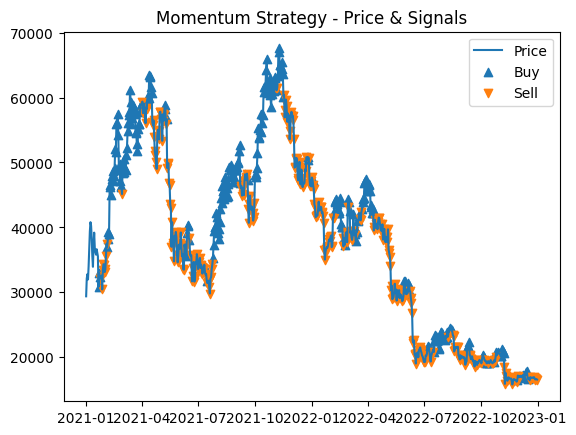

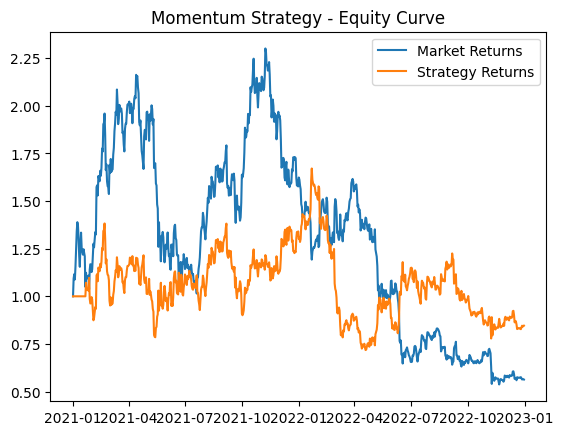

In [5]:
data = download_data("BTC-USD", "2021-01-01", "2023-01-01")
data = momentum_signals(data, lookback=20)
data, metrics = backtest_strategy(data, initial_capital=10000)

print("Performance Metrics:")
for k,v in metrics.items():
    print(f"{k}: {v}")

plot_results(data)